<a href="https://colab.research.google.com/github/kvakhil/Machine-Learning-CS-545/blob/main/Building_a_Neural_Network_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Class" data-toc-modified-id="Neural-Network-Class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Class</a></span></li><li><span><a href="#QSAR-aquatic-toxicity-Data-Set" data-toc-modified-id="QSAR-aquatic-toxicity-Data-Set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>QSAR aquatic toxicity Data Set</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Check-In" data-toc-modified-id="Check-In-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check-In</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# Neural Network Class

* A3.3: *Modified `A3grader.tar` to correctly grade the `error_trace` value.  It now assumes you use the following function for the `error_convert_f`:

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)

* A3.2: *Added `A3grader.py` and additional requirements involving application of your `NeuralNetwork` class to a specific data set.*
* A3.1: *Added some details on specifications of required functions and many examples of running your implementation.*

You will define a new class named `NeuralNetwork` that constructs a neural network with any number of hidden layers.  To train the neural network, you will use our `optimizers.py` code. Use this updated version: [optimizers.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar).  Your class must implement at least the following functions. Lecture Notes 07 provide examples of some of the code in the section about using `Optimizers` on which you can base your implementation.

* `__init__(self, n_inputs, n_hiddens_list, n_outputs)`: 
* `__repr__(self):`
* `make_weights(self):` called from constructor `__init__`
* `initialize_weights(self):` called from constructor `__init__`
* `train(self, X, T, n_epochs, learning_rate, method='adam', verbose=True):` `method` can be 'sgd', 'adam', or 'scg'. Must first calculate standarization parameters, stored in `stand_params` dictionary, and standardize `X` and `T`.  Import `optimizers.py` and use these optimizers in this `train` function. Use the `tanh` activation function.
* `use(self, X, return_hidden_layer_outputs=False):` standardizes X then calculates the output of the network by calling `forward` and unstandardizing the network output. Returns just the output of the last layer. If `return_hidden_layer_outputs` is `True`, return two things, the output of the last layer and a list of outputs from each hidden layer.
* `get_error_trace(self):` just returns the `error_trace`

Here are some example uses of your `NeuralNetwork` class.  Your implementation should return very close to the same values in each code cell.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt

In [ ]:
class NeuralNetwork():

    def __init__(self,n_inputs,n_hiddens_list,n_outputs):
        
        self.n_inputs=n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        # self.stand_parms = None
        self.n_layers=len(n_hiddens_list)+1

        self.all_weights, self.Ws, self.shapes = self.make_weights()

        self.all_gradients,self.Gs,_ = self.make_weights()

        self.error_trace = None
        self.initialize_weights()

    def __repr__(self):
        return f'Neuralnetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'

    def error_convert(self,err):
      if self.T.shape[1] == 1:
          return np.sqrt(err) * self.stand_params['Tstds']
      else:
          # Can't unstandardize err if more than one network output
          return np.sqrt(err)

    def forward(self,Xst):
        # Calculate the outputs, Z, of all hidden units, given all input samples in X.
        output_list=[]
        for W in self.Ws:
          Z = np.tanh(self.add_ones(Xst) @ W)
          output_list.append(Z);
          Xst=Z
        output_list.pop()
        # Calculate the outputs, Y, of all output units, given all outputs of the hidden units.
        Yst = self.add_ones(output_list[-1]) @ self.Ws[-1]
        output_list.append(Yst)
        return output_list
    

    def backward(self,Xst, Tst):

        global Gs
        n_samples = Xst.shape[0]
        n_outputs = Tst.shape[1]
        # Calculate the outputs of both layers.
        outs= self.forward(Xst)
        
        # Calculate the delta value for the output layer. Divide by n_samples * n_outputs
        # because we are calculating the gradient of the mean sqauared error with respect to weights.
        delta = -(Tst -  outs[-1]) /  (n_samples * n_outputs)
        # The gradient of the mean squared error with respect to the output layer weights W.
        self.Gs[-1][:] = (self.add_ones(outs[-2]).T @ delta) *2
        # gradients.append(gradient_W)
        # Back-propagate the delta value from the output layer, through the output layer weights,
        # to the hidden units.  Multiply the result by the derivative of the hidden units'
        # activation function, tanh
        for i in range(len(self.Ws)-2):
          delta = (delta @ self.Ws[-1*(i+1)][1:, :].T) * (1 - outs[-1*(i+2)] ** 2)
        # The gradient of the mean squared error with respect to the hidden layer weights, V.
          self.Gs[-1*(i+2)][:] = (self.add_ones(outs[-1*(i+3)]).T @ delta)*2
          # gradients.append(gradient_V)

        delta = (delta @ self.Ws[1][1:, :].T) * (1 - outs[0] ** 2)
        self.Gs[0][:] = (self.add_ones(Xst).T @ delta) *2
        # gradients.append(gradient_V)
        # Return both gradients.  Each should be the same shape as the respective weight matrices.
        # gradients.reverse()
        return self.all_gradients

    def use(self,X,return_hidden_layer_outputs=False):
        # Standardize inputs X
        Xst = self.standardize_X(X,self.stand_params)
        # Calculate outputs of each layer.
        self.outs = self.forward(Xst)
        Yst=self.outs[-1]
        self.outs.pop()
        Yst=self.unstandardize_T(Yst,self.stand_params)
        self.outs.append(Yst)

        if (return_hidden_layer_outputs==True):
            return self.outs[-1],self.outs[:-1]
        # else:
          # Unstandardize output of output layer
        return self.outs[-1]
    

    

    def mse_error(self,Xst, Tst):
        self.Yst = self.forward(Xst)
        return np.mean((Tst - self.Yst[-1])**2)

  
    
    def train(self, X, T, n_epochs, learning_rate, method, verbose=True):
        
        # Standardising input
        self.stand_params = self.calc_standardize_parameters(X, T)

        self.T = T
        
        Xst = self.standardize_X(X, self.stand_params)
        Tst = self.standardize_T(T, self.stand_params)
        
        
        optimize = opt.Optimizers(self.all_weights)
        
        if method == 'adam':
            error_trace = optimize.adam(self.mse_error, self.backward,
                                        fargs=[Xst, Tst], n_epochs=n_epochs,
                                        learning_rate=learning_rate, error_convert_f = self.error_convert)
        elif method == 'sgd':

            error_trace = optimize.sgd(self.mse_error, self.backward,
                                     fargs=[Xst, Tst], n_epochs=n_epochs,
                                     learning_rate=learning_rate, error_convert_f = self.error_convert)
            
            
        elif method == 'scg':

            error_trace = optimize.scg(self.mse_error, self.backward,
                                     fargs=[Xst, Tst], n_epochs=n_epochs,
                                     learning_rate=learning_rate, error_convert_f = self.error_convert)
            
            
            
        self.error_trace = error_trace
        
        return self.stand_params, self.error_trace 
    #     # return self.error_trace   
            
    
   

    def calc_standardize_parameters(self,X, T):
        self.Xmeans = X.mean(axis=0)
        self.Xstds = X.std(axis=0)
        self.Tmeans = T.mean(axis=0)
        self.Tstds = T.std(axis=0)
        return {'Xmeans': self.Xmeans, 'Xstds': self.Xstds,
                'Tmeans': self.Tmeans, 'Tstds': self.Tstds}

    

    def standardize_X(self,X, stand_params):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']


    def unstandardize_X(self,Xst, stand_params):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']


    def standardize_T(self,T, stand_params):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']


    def unstandardize_T(self,Tst, stand_params):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']
    
    def add_ones(self,X):
      return np.insert(X, 0, 1, axis=1)


    def initialize_weights(self):

        for i in range(len(self.Ws)):
            self.Ws[i][:]=np.random.uniform(-1, 1, size=(self.shapes[i][0], self.shapes[i][1]))/ np.sqrt( self.shapes[i][0])



    def make_weights(self):

        shapes = [(1+self.n_inputs, self.n_hiddens_list[0])]

        for i in range(len(self.n_hiddens_list)-1):
            shapes.append((1+self.n_hiddens_list[i], self.n_hiddens_list[i+1]))
        
        shapes.append((1+self.n_hiddens_list[-1],self.n_outputs))
        
        n_w= sum([i*j for (i,j) in shapes])

        all_weights = np.zeros(n_w)

        # print(all_weights)

        start=0
        Ws = []

        for (i, j) in shapes:
          layer_weights = i*j
          w = all_weights[start: start+layer_weights].reshape(i,j)
          Ws.append(w)
          start+= layer_weights
          
        return all_weights, Ws, shapes

    def get_error_trace(self):
        return self.error_trace

        

      







In [ ]:
np.random.seed(123)
nnet = NeuralNetwork(1, [3], 2)  # 2 outputs
nnet

Neuralnetwork(1, [3], 2)

In [ ]:
nnet.all_weights

array([ 0.27784939, -0.30244465, -0.38629038,  0.07257004,  0.31037599,
       -0.10874389,  0.4807642 ,  0.18482974, -0.0190681 , -0.10788248,
       -0.15682198,  0.22904971, -0.06142776, -0.4403221 ])

In [ ]:
nnet.Ws

[array([[ 0.27784939, -0.30244465, -0.38629038],
        [ 0.07257004,  0.31037599, -0.10874389]]),
 array([[ 0.4807642 ,  0.18482974],
        [-0.0190681 , -0.10788248],
        [-0.15682198,  0.22904971],
        [-0.06142776, -0.4403221 ]])]

In [ ]:
nnet.all_gradients

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
nnet.Gs

[array([[0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

In [ ]:
X = np.linspace(-1, 1, 4).reshape(-1, 1)
X

array([[-1.        ],
       [-0.33333333],
       [ 0.33333333],
       [ 1.        ]])

In [ ]:
T = np.hstack((X ** 2, (X - 2) ** 3))
T

array([[  1.        , -27.        ],
       [  0.11111111, -12.7037037 ],
       [  0.11111111,  -4.62962963],
       [  1.        ,  -1.        ]])

In [ ]:
nnet.train(X, T, 5, 0.01, method='adam')

Adam: Epoch 1 Error=1.04625
Adam: Epoch 2 Error=1.03472
Adam: Epoch 3 Error=1.02343
Adam: Epoch 4 Error=1.01223
Adam: Epoch 5 Error=1.00111


({'Tmeans': array([  0.55555556, -11.33333333]),
  'Tstds': array([0.44444444, 9.98799004]),
  'Xmeans': array([-5.55111512e-17]),
  'Xstds': array([0.74535599])},
 [1.0462527456866673,
  1.0347196138595187,
  1.0234280115224064,
  1.0122313682158668,
  1.0011130457971062])

In [ ]:
nnet.Gs

[array([[-0.05090467, -0.0454069 , -0.10866125],
        [ 0.11280118, -0.1552129 ,  0.33065424]]),
 array([[ 0.45676396,  0.18176547],
        [ 0.13959465,  0.03152188],
        [-0.13673716, -0.29306245],
        [-0.14982828,  0.05032327]])]

In [ ]:
nnet.all_gradients

array([-0.05090467, -0.0454069 , -0.10866125,  0.11280118, -0.1552129 ,
        0.33065424,  0.45676396,  0.18176547,  0.13959465,  0.03152188,
       -0.13673716, -0.29306245, -0.14982828,  0.05032327])

In [ ]:
nnet.stand_params

{'Tmeans': array([  0.55555556, -11.33333333]),
 'Tstds': array([0.44444444, 9.98799004]),
 'Xmeans': array([-5.55111512e-17]),
 'Xstds': array([0.74535599])}

In [ ]:
nnet.Ws

[array([[ 0.32805609, -0.25283707, -0.33680913],
        [ 0.02237977,  0.36049589, -0.15868899]]),
 array([[ 0.43097923,  0.13534218],
        [-0.06903616, -0.15739471],
        [-0.10716161,  0.27902101],
        [-0.01180826, -0.44858975]])]

In [ ]:
nnet.get_error_trace()

[1.0462527456866673,
 1.0347196138595187,
 1.0234280115224064,
 1.0122313682158668,
 1.0011130457971062]

In [ ]:
nnet.use(X)

array([[  0.76872931, -11.63174677],
       [  0.75768845, -10.3937065 ],
       [  0.74348724,  -9.01615633],
       [  0.72838516,  -7.64787959]])

In [ ]:
Y, Zs = nnet.use(X, return_hidden_layer_outputs=True)
Y, Zs  # Zs is list of hidden layer output matrices

(array([[  0.76872931, -11.63174677],
        [  0.75768845, -10.3937065 ],
        [  0.74348724,  -9.01615633],
        [  0.72838516,  -7.64787959]]),
 [array([[ 0.2895092 , -0.62702167, -0.12327529],
         [ 0.30774044, -0.39191092, -0.25975089],
         [ 0.32574848, -0.09136292, -0.38658353],
         [ 0.34352322,  0.22680528, -0.50030489]])])

Now here is a function you may use to train a `NeuralNetwork` using a particular method and values for the number of epochs and learning rate.

In [ ]:
def run(method, n_epochs, learning_rate=0):
    
    n_samples = 30
    Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
    Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
    Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    n_inputs = Xtrain.shape[1]
    n_hiddens_list = [50, 20, 20]
    n_outputs = Ttrain.shape[1]
    
    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    plt.figure(1, figsize=(10, 10))
    plt.clf()

    n_plot_rows = nnet.n_layers + 1
    ploti = 0

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(nnet.get_error_trace())
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
    plt.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
    plt.plot(X_for_plot, Y, label='Neural Net Output')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')

    for layeri in range(nnet.n_layers - 2, -1, -1):
        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(X_for_plot, Zs[layeri])
        plt.xlabel('X')
        plt.ylabel(f'Outputs from Layer {layeri}')
        
    return nnet

sgd: Epoch 400 Error=0.22721
sgd: Epoch 800 Error=0.16875
sgd: Epoch 1200 Error=0.14802
sgd: Epoch 1600 Error=0.13548
sgd: Epoch 2000 Error=0.13208
sgd: Epoch 2400 Error=0.13066
sgd: Epoch 2800 Error=0.12974
sgd: Epoch 3200 Error=0.12915
sgd: Epoch 3600 Error=0.12888
sgd: Epoch 4000 Error=0.12843
Method: sgd, RMSE: Train 0.13 Test 0.28


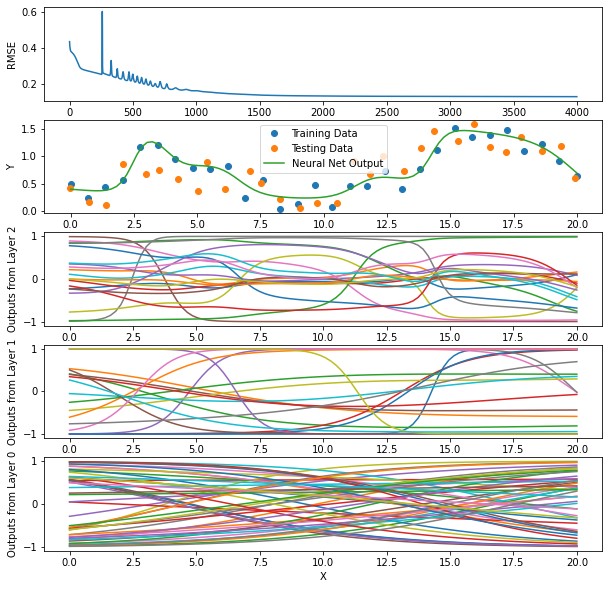

In [ ]:
run('sgd', 4000, 0.1)

Adam: Epoch 200 Error=0.18749
Adam: Epoch 400 Error=0.12221
Adam: Epoch 600 Error=0.09956
Adam: Epoch 800 Error=0.08557
Adam: Epoch 1000 Error=0.08227
Adam: Epoch 1200 Error=0.08200
Adam: Epoch 1400 Error=0.08318
Adam: Epoch 1600 Error=0.07989
Adam: Epoch 1800 Error=0.07677
Adam: Epoch 2000 Error=0.07465
Method: adam, RMSE: Train 0.07 Test 0.26


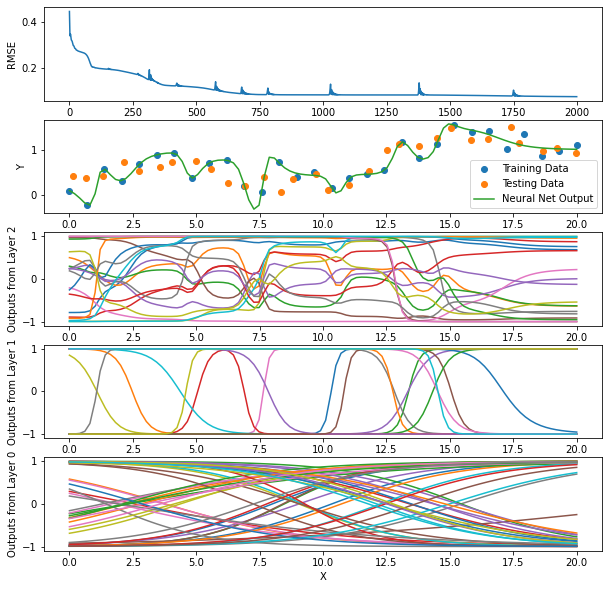

In [ ]:
run('adam', 2000, 0.01)

SCG: Epoch 200 Error=0.14571
SCG: Epoch 400 Error=0.06806
SCG: Epoch 600 Error=0.06075
SCG: Epoch 800 Error=0.02098
SCG: Epoch 1000 Error=0.01048
SCG: Epoch 1200 Error=0.00483
SCG: Epoch 1400 Error=0.00192
SCG: Epoch 1600 Error=0.00080
SCG: Epoch 1800 Error=0.00004
SCG: Epoch 2000 Error=0.00001
Method: scg, RMSE: Train 0.00 Test 0.31


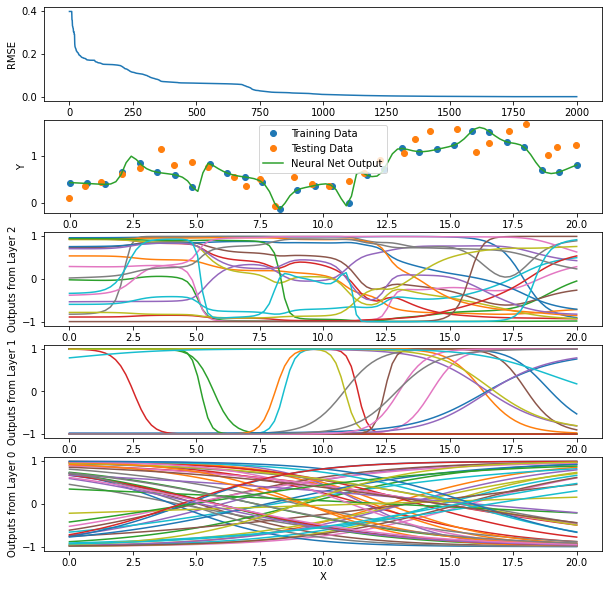

In [ ]:
run('scg', 2000)

#  QSAR aquatic toxicity Data Set

Download the QSAR data set from [this UCI ML Repository site](https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity). It consists of eight measurements of water quality that may affect a ninth measurement, of aquatic toxicity towards [Daphnia Magna](https://en.wikipedia.org/wiki/Daphnia_magna#:~:text=Daphnia%20magna%20is%20a%20small,Northern%20Hemisphere%20and%20South%20Africa.).

Your job is to
* read this data into a numpy array,
* randomly shuffle the order of the rows in this data array (`np.random.shuffle`)
* take the first 500 rows as training data and the remaining rows as testing data,
* assign the first eight columns to `Xtrain` and `Xtest`, and the last column to `Ttrain` and `Ttest`,
* do some experimentation with different values of `n_hiddens_list`, `n_epochs` and `learning_rate` for the `sgd` and `adam` methods, and with different values of `n_hiddens_list`, `n_epochs` for `scg`, which does not use the `learning_rate`.
* using the parameter values (`n_hiddens_list`, `n_epochs` and `learning_rate`) that you find produce the lowest RMSE on test data for each method, create plots for each method that include the `error_trace`, the training data targets and predictions by the neural network, and the testing data targets and predictions by the neural network. The differrent methods may use different parameter values.

Describe your results with at least 10 sentences.

Here is an example of the plots we expect to see.

<img src="https://www.cs.colostate.edu/~anderson/cs545/notebooks/A3figure.png" width="800"/>

In [ ]:
from numpy import genfromtxt

aqua_toxic = genfromtxt('qsar_aquatic_toxicity.csv', delimiter=';')

toxic = np.array(aqua_toxic)

toxic

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  3.74 ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  4.33 ],
       [ 9.23 , 11.   ,  0.   , ...,  0.   ,  0.   ,  7.019],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  6.219],
       [13.14 ,  9.507,  0.   , ...,  0.   ,  0.   ,  4.995],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  2.48 ]])

In [ ]:
np.random.shuffle(toxic)
len(toxic)

546

In [ ]:
train = toxic[:500]
test  = toxic[-46:]

Xtrain = train[:,:8]
Ttrain = train[:,[-1]]

Xtest = test[:,:8]
Ttest = test[:,[-1]]

print(test[1])
print(Xtest[1])
print(Ttest[1])
Ttest.shape

[45.61  28.269  0.     1.971  2.294  1.275  1.     0.     4.608]
[45.61  28.269  0.     1.971  2.294  1.275  1.     0.   ]
[4.608]


(46, 1)

In [ ]:
n_inputs=8
n_hiddens=[5,4,3]
n_epoches= 500
learning_rate= 0.01
nnet = NeuralNetwork(n_inputs, n_hiddens, 1)  
nnet

In [ ]:
def runToxic(method, n_epochs, n_hiddens_list, Xtrain, Xtest, Ttrain, Ttest, learning_rate=0):
    
    # n_samples = 30
    # Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
    # Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    # Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
    # Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    n_inputs = Xtrain.shape[1]
    n_hiddens_list = [50, 20, 20]
    n_outputs = Ttrain.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    n_plot_rows = nnet.n_layers + 1
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    # ploti = 0
    
    
    plt.figure(figsize=(17, 17))
    plt.subplot(3, 1, 1)
    plt.plot(nnet.get_error_trace())
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Method '+method)


    plt.subplot(3, 1, 2)
    Ytrain = nnet.use(Xtrain)
    plt.plot(Ttrain, 'o', label='actual Ttrain')
    plt.plot(Ytrain,'-', label='Predicted Ttrain')
    plt.xlabel('Sample Index')
    plt.ylabel('Toxicity')
    plt.legend()
    

    plt.subplot(3, 1, 3)
    Ytest = nnet.use(Xtest)
    plt.plot(Ttest, 'o', label='actual Ttest')
    plt.plot(Ytest,'-', label='Predicted Ttest')
    plt.xlabel('Sample Index')
    plt.ylabel('Toxicity')
    plt.legend()


    
    return nnet


sgd: Epoch 400 Error=1.16947
sgd: Epoch 800 Error=1.13785
sgd: Epoch 1200 Error=1.11903
sgd: Epoch 1600 Error=1.09981
sgd: Epoch 2000 Error=1.07930
sgd: Epoch 2400 Error=1.05718
sgd: Epoch 2800 Error=1.03243
sgd: Epoch 3200 Error=1.00421
sgd: Epoch 3600 Error=0.97437
sgd: Epoch 4000 Error=0.94799
Method: sgd, RMSE: Train 0.95 Test 1.33


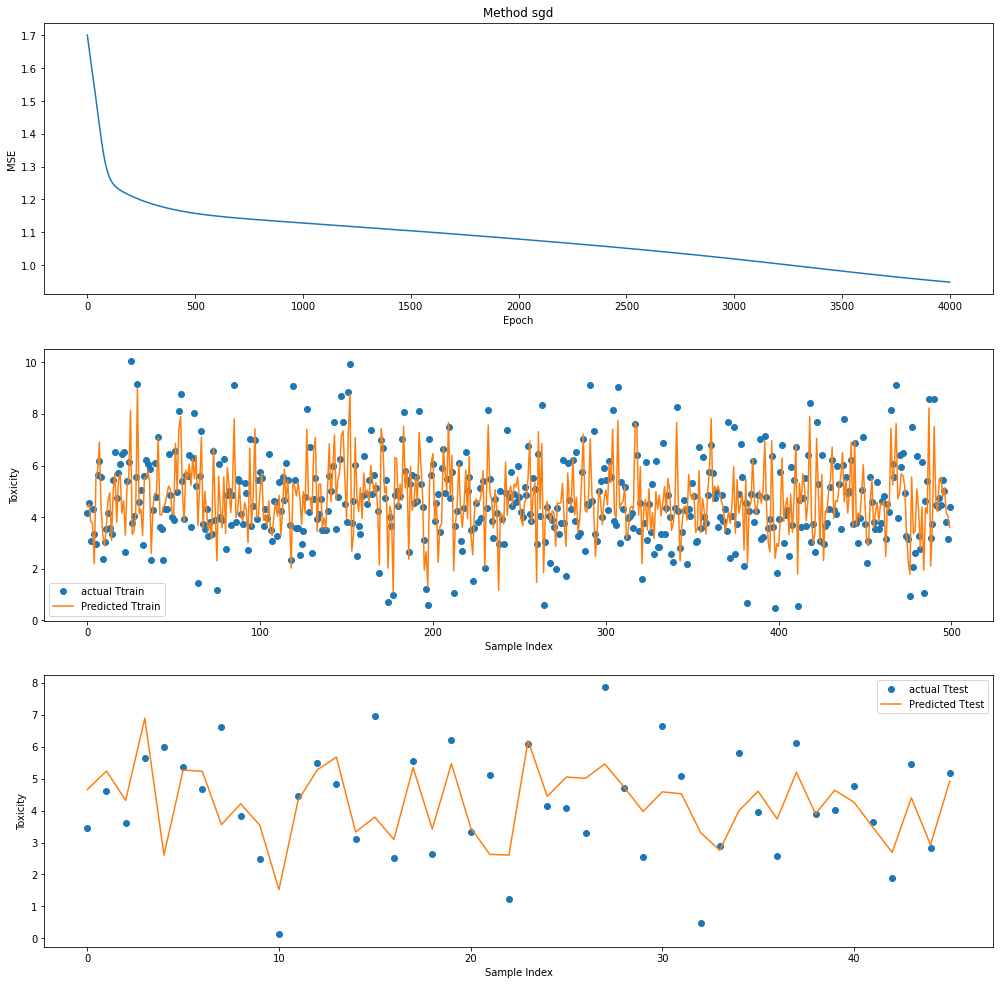

In [ ]:
runToxic('sgd',4000,[10,5,7],Xtrain,Xtest,Ttrain,Ttest,learning_rate=0.01)

sgd: Epoch 400 Error=0.97483
sgd: Epoch 800 Error=0.90315
sgd: Epoch 1200 Error=0.83590
sgd: Epoch 1600 Error=0.76727
sgd: Epoch 2000 Error=0.70479
sgd: Epoch 2400 Error=0.64680
sgd: Epoch 2800 Error=0.58838
sgd: Epoch 3200 Error=0.59131
sgd: Epoch 3600 Error=0.50826
sgd: Epoch 4000 Error=0.47740
Method: sgd, RMSE: Train 0.48 Test 1.47


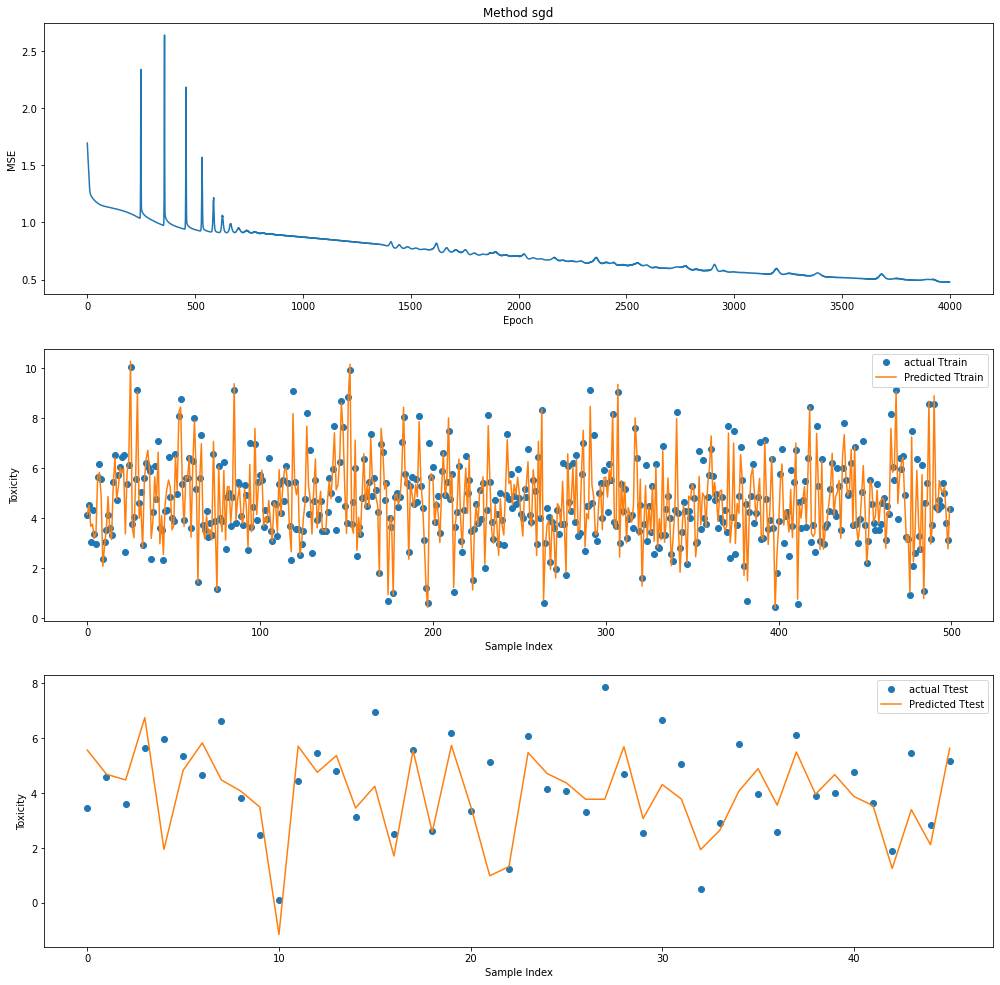

In [ ]:
runToxic('sgd',4000,[10]*20,Xtrain,Xtest,Ttrain,Ttest,learning_rate=0.1)

# Observation for SGD optimizer

*   The best test accuracy I got for this optimizer is 1.29 4000 epoches, n_hiddens_list=[10,5,7]and learning_rate=0.01. I observed that increasing the learning rate increases the train accuracy but the test accuracy does not improve much, moverover gets worse sometimes.Increasing the learning rate beyond 0.5 results in blowing up. Onthe other hand decreasing the learning rate results in better train accuracy.

*   A higher learning rate that is above 0.1 results in spikes in the error trace. Whrereas, Reducing the learning rate to 0.01 results in a very smooth error trace.


*   Increasing the number of hidden layers results in better test acccuracy but again very small. I observed that the number of units beyond 10 is not making much difference unless the learning rate is not proper. 
*   Since the dataset is not so big the first 2-3 layers are learning most of the features. Having  more than layers than five is not making a difference.





SCG: Epoch 2 Error=1.60282
SCG: Epoch 4 Error=1.41438
SCG: Epoch 6 Error=1.25778
SCG: Epoch 8 Error=1.21122
SCG: Epoch 10 Error=1.17607
SCG: Epoch 12 Error=1.14348
SCG: Epoch 14 Error=1.13364
SCG: Epoch 16 Error=1.12495
SCG: Epoch 18 Error=1.11652
SCG: Epoch 20 Error=1.10212
Method: scg, RMSE: Train 1.09 Test 1.28


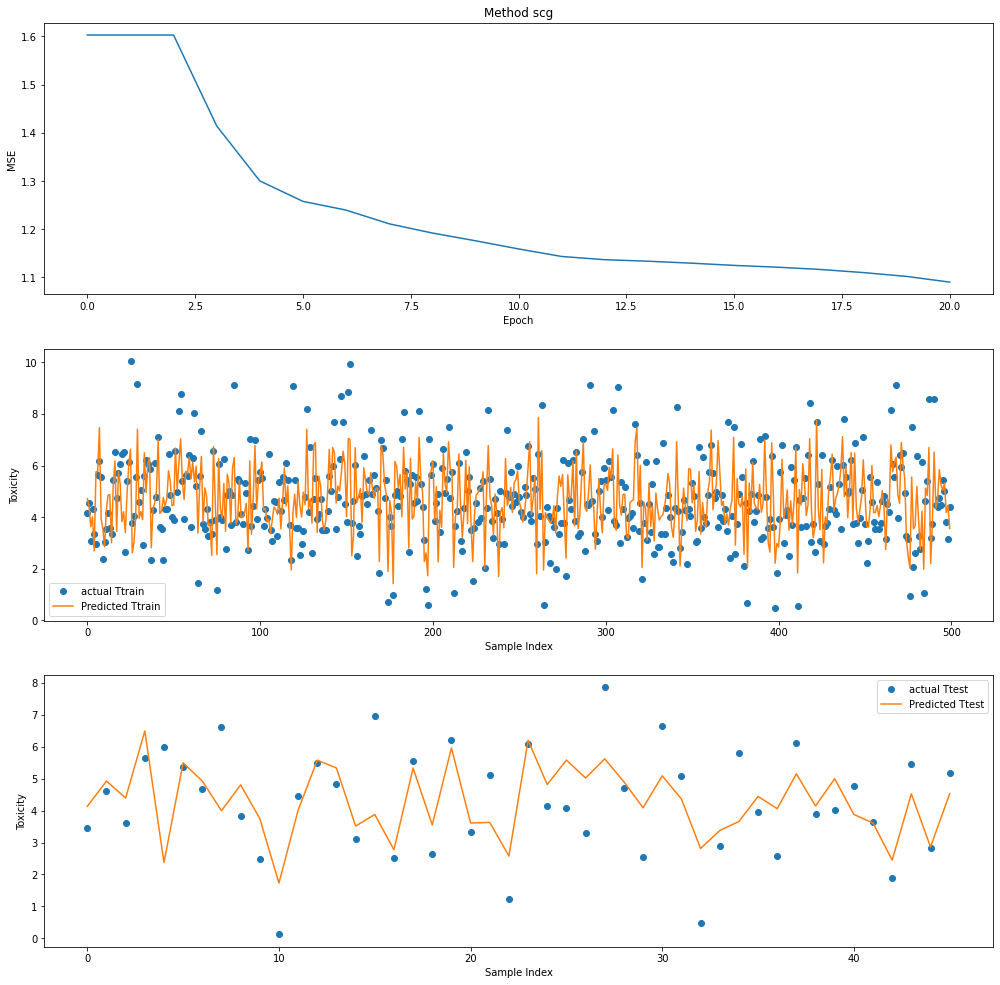

In [ ]:
runToxic('scg',20,[30,20,10],Xtrain,Xtest,Ttrain,Ttest)

SCG: Epoch 100 Error=0.80778
SCG: Epoch 200 Error=0.61982
SCG: Epoch 300 Error=0.49109
SCG: Epoch 400 Error=0.39480
SCG: Epoch 500 Error=0.33644
SCG: Epoch 600 Error=0.28582
SCG: Epoch 700 Error=0.24909
SCG: Epoch 800 Error=0.22447
SCG: Epoch 900 Error=0.21028
SCG: Epoch 1000 Error=0.19923
Method: scg, RMSE: Train 0.20 Test 2.05


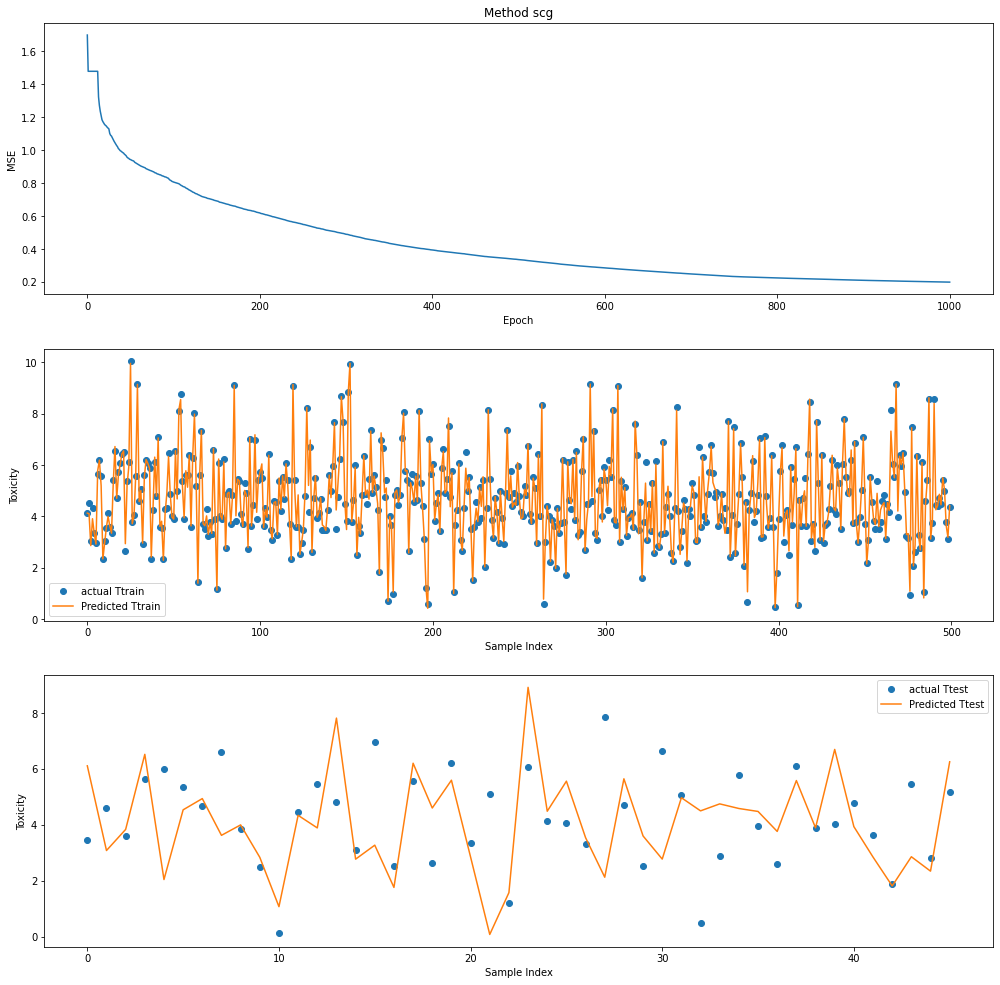

In [ ]:
runToxic('scg',1000,[30,20,10],Xtrain,Xtest,Ttrain,Ttest)

# Observations for SCG

*   SCG behaves very differently compared to the rest. While other optimizers had increased test accuracy with the increase in the number of epoches, SCG's test accuracy decreased. The lower the number of epoches the higher the test accuracy for SCG.  

*   The best test accuracy I got was 1.21 for 20 epoches, n_hiddensLlist=[30,20,10]. SCG jumps to a minima very quickly compared to the other optimizers. The train error for SCG is not as good as the other optimizers.

*   Increasing the number of layers beyond 3-4 and the number of units beyond 10 did not make much effect infact sometimes resulted in increases error.






Adam: Epoch 80 Error=1.53365
Adam: Epoch 160 Error=1.31252
Adam: Epoch 240 Error=1.23273
Adam: Epoch 320 Error=1.25527
Adam: Epoch 400 Error=1.22177
Adam: Epoch 480 Error=1.10474
Adam: Epoch 560 Error=1.07558
Adam: Epoch 640 Error=1.10116
Adam: Epoch 720 Error=1.04380
Adam: Epoch 800 Error=1.03011
Method: adam, RMSE: Train 1.02 Test 1.40


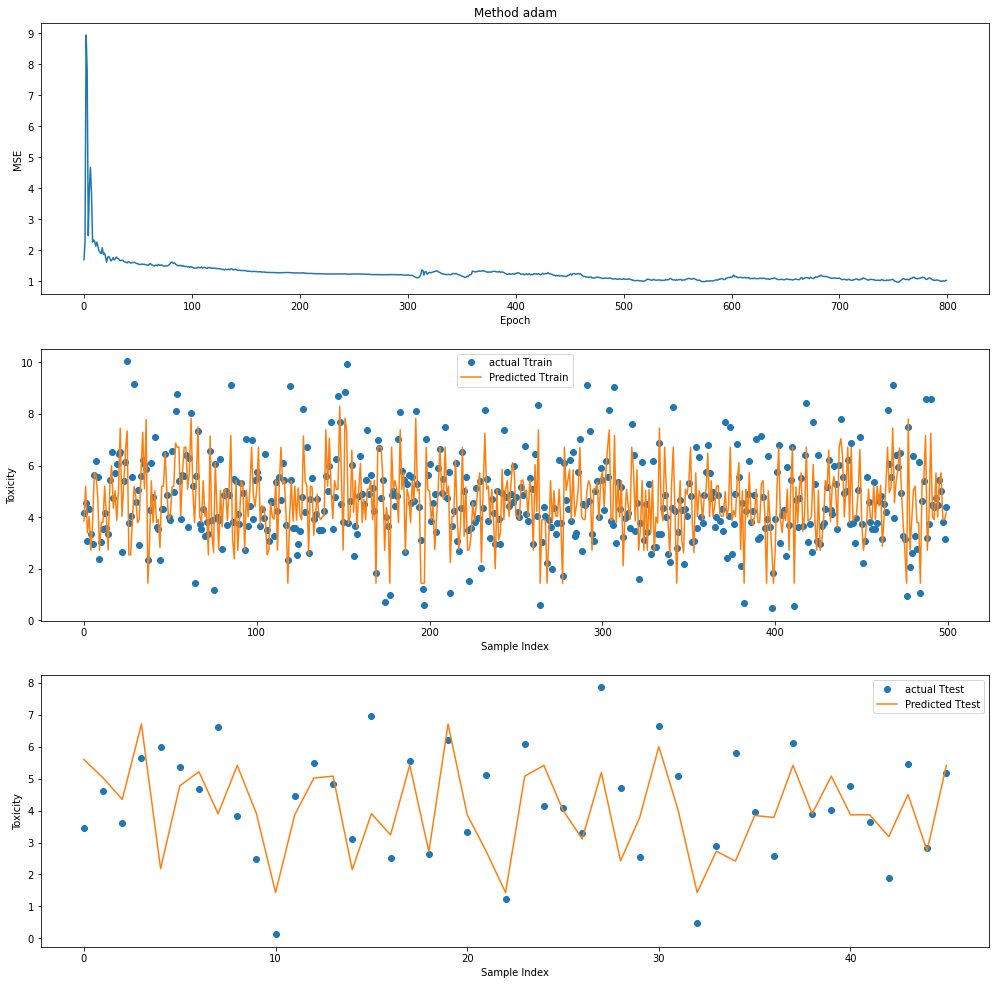

In [ ]:
runToxic('adam',800,[10,5,7],Xtrain,Xtest,Ttrain,Ttest,learning_rate=0.4)

Adam: Epoch 80 Error=0.86533
Adam: Epoch 160 Error=0.62672
Adam: Epoch 240 Error=0.50485
Adam: Epoch 320 Error=0.44451
Adam: Epoch 400 Error=0.39027
Adam: Epoch 480 Error=0.36137
Adam: Epoch 560 Error=0.32964
Adam: Epoch 640 Error=0.31676
Adam: Epoch 720 Error=0.28496
Adam: Epoch 800 Error=0.28276
Method: adam, RMSE: Train 0.33 Test 1.91


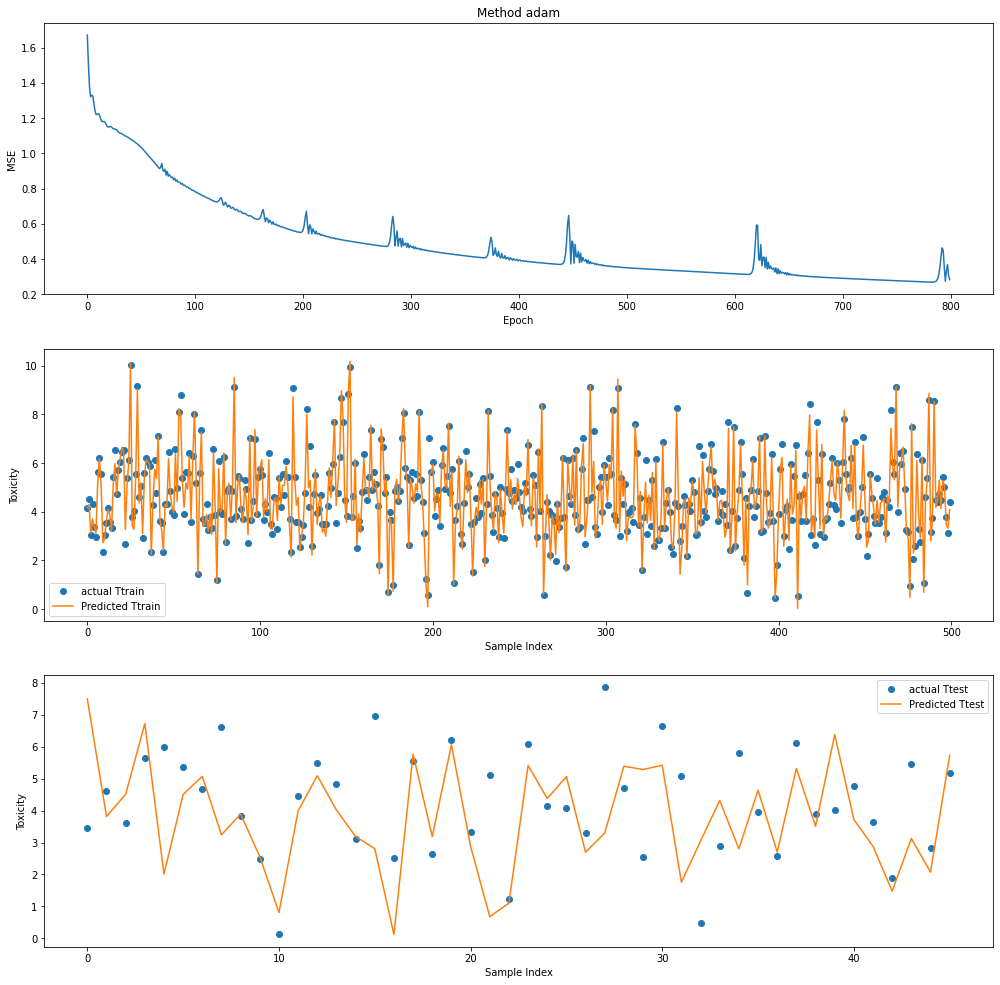

In [ ]:
runToxic('adam',800,[100,50,7],Xtrain,Xtest,Ttrain,Ttest,learning_rate=0.01)

# Observation for Adam



*   Error converges in less number of epoches compared to sgd. While sgd requires around 5000, adam requires only around 1000.
*   Increasing the number of layers resulted in worse test accuracies, I believe it is because of overfitting.

*   The best accuracy I could get for this is 1.35 for 800 epoches,nhiddens=[10,5,7]and learning_rate=0.4. Even though the train accuracy was sometimes very high the test accuracy is very low.
*   There are quite a few spikes in the error trace contantly. I observed this to be more significant with smaller learning rates which I felt is a little odd.





# Some General Observations

*   Number of layers beyond 4 or 5 is not so useful in my opinion. Rather, increasing the number units resulted in better accuracies sometimes. Increasing the number of layers and units drastically mostly resulted in overfitting the train data resulting in good train accuracies and worst test accuracies.
*   SCG takes the least number of steps to reach the minimum. Sgd gives better accuracy than adam but takes more than double the number of epoches than adam.

*   I feel that if the right learning rate and number of epoches is found then the number of layers needed would be less.






# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 40 points will be based on other testing and the results you obtain and your discussions. 

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A3.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [ ]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'kakumanu-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: Function named 'NeuralNetworks' is not defined
  Check the spelling and capitalization of the function name.

## Testing constructor ####################################################################

    nnet = NeuralNetwork(2, [5, 4], 3)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    nnet.Ws[0][2, 0] = 100.0
    # Does nnet.Ws[0][2, 0] == nnet.all_weights[10]


--

<Figure size 432x288 with 0 Axes>

# Check-In

Do not include this section in your notebook.

Name your notebook ```Lastname-A3.ipynb```.  So, for me it would be ```Anderson-A3.ipynb```.  Submit the file using the ```Assignment 3``` link on [Canvas](https://colostate.instructure.com/courses/109894).

# Extra Credit

Earn one extra credit point by downloading a second, real data set and repeating the above experiments.